# Notebook for preprocessing the LOFAR catalogues before XID+

it outputs a modified LOFAR radio data table with two new columns. the first column is XID+_rerun and is a boolean array stating whether a source should ahve XID+ rerun or not. The second is a string column that says what where the fir for that source comes from.

In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
#from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo
#from herschelhelp_internal.utils import inMoc




In [2]:
def best_irac(swire,servs):
    mask = np.isnan(swire)
    swire[mask] = 10000
    mask = np.isnan(servs)
    servs[mask] = 10000
    swire_mask = swire<servs
    return(swire_mask)

In [3]:
lofar01 = Table.read('data/data_release/final_cross_match_catalogue-v0.1.fits')
lofar05 = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
new_x_old = join(lofar05,lofar01,join_type='left',keys='Source_Name')

mask = new_x_old['optRA_1']==new_x_old['optRA_2']
lofar = lofar05[~mask]

In [4]:
#Read in the LOFAR data and select sources with no FIR measurements from XID+
#lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.1.fits')
mask = (~np.isnan(lofar['F_MIPS_24']))
lofar = lofar[~mask]

ras = lofar['optRA']
mask = np.isnan(ras)
print(np.sum(mask))
ras[mask] = lofar['RA'][mask]

decs = lofar['optDec']
mask = np.isnan(decs)
print(np.sum(mask))
decs[mask] = lofar['DEC'][mask]

ids = lofar['Source_Name']

697
697


In [5]:
len(lofar)

1027

In [6]:
#Read in the HELP masterlist and select the wanted columns
columns = 'ra','dec','help_id','flag_optnir_det','f_irac_i1','f_irac_i2','f_irac_i3','f_irac_i4'
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')
help_masterlist = masterlist[columns]

In [7]:
masterlist[0]

help_id,field,ra,dec,hp_idx,ebv,redshift,zspec,f_wfc_u,ferr_wfc_u,f_ap_wfc_u,ferr_ap_wfc_u,m_wfc_u,merr_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,flag_wfc_u,f_megacam_u,ferr_megacam_u,f_ap_megacam_u,ferr_ap_megacam_u,m_megacam_u,merr_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,flag_megacam_u,f_suprime_g,ferr_suprime_g,f_ap_suprime_g,ferr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_g,merr_ap_suprime_g,flag_suprime_g,f_megacam_g,ferr_megacam_g,f_ap_megacam_g,ferr_ap_megacam_g,m_megacam_g,merr_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,flag_megacam_g,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_wfc_g,ferr_wfc_g,f_ap_wfc_g,ferr_ap_wfc_g,m_wfc_g,merr_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,flag_wfc_g,f_suprime_r,ferr_suprime_r,f_ap_suprime_r,ferr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_r,merr_ap_suprime_r,flag_suprime_r,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_wfc_r,ferr_wfc_r,f_ap_wfc_r,ferr_ap_wfc_r,m_wfc_r,merr_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,flag_wfc_r,f_megacam_r,ferr_megacam_r,f_ap_megacam_r,ferr_ap_megacam_r,m_megacam_r,merr_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,flag_megacam_r,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_suprime_i,ferr_suprime_i,f_ap_suprime_i,ferr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_i,merr_ap_suprime_i,flag_suprime_i,f_wfc_i,ferr_wfc_i,f_ap_wfc_i,ferr_ap_wfc_i,m_wfc_i,merr_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,flag_wfc_i,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_wfc_z,ferr_wfc_z,f_ap_wfc_z,ferr_ap_wfc_z,m_wfc_z,merr_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,flag_wfc_z,f_megacam_z,ferr_megacam_z,f_ap_megacam_z,ferr_ap_megacam_z,m_megacam_z,merr_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,flag_megacam_z,f_suprime_z,ferr_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_z,merr_ap_suprime_z,flag_suprime_z,f_suprime_n921,ferr_suprime_n921,f_ap_suprime_n921,ferr_ap_suprime_n921,m_suprime_n921,merr_suprime_n921,m_ap_suprime_n921,merr_ap_suprime_n921,flag_suprime_n921,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_suprime_y,ferr_suprime_y,f_ap_suprime_y,ferr_ap_suprime_y,m_suprime_y,merr_suprime_y,m_ap_suprime_y,merr_ap_suprime_y,flag_suprime_y,f_ukidss_j,ferr_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,flag_ukidss_j,f_ukidss_k,ferr_ukidss_k,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,flag_ukidss_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,flag_irac_i2,f_irac_i3,ferr_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_irac_i3,merr_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,flag_irac_i3,f_irac_i4,ferr_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,m_irac_i4,merr_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,flag_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag
,,deg,deg,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [11]:
lofar[0]

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,flo

In [8]:
mips_mask = (help_masterlist['flag_optnir_det']>=5) #& (help_masterlist['f_mips_24']>20)

prior_cat = help_masterlist[mips_mask]
print('number of help prior sources is: {}'.format(len(prior_cat)))

number of help prior sources is: 432066


In [9]:
MIPS_lower=np.full(len(prior_cat),0.0)
MIPS_upper=np.full(len(prior_cat),1E5)
for i in range(len(prior_cat)):
    if np.isnan(prior_cat['f_irac_i4'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i4'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i4'][i]*500.0
    elif np.isnan(prior_cat['f_irac_i3'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i3'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i3'][i]*500.0
    elif np.isnan(prior_cat['f_irac_i2'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i2'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i2'][i]*500.0
    elif np.isnan(prior_cat['f_irac_i1'][i])==False:
        MIPS_lower[i]=prior_cat['f_irac_i1'][i]/500.0
        MIPS_upper[i]=prior_cat['f_irac_i1'][i]*500.0
        
mips_lower_col = Column(MIPS_lower,name='MIPS_lower')
mips_upper_col = Column(MIPS_upper,name='MIPS_upper')
prior_cat.add_columns([mips_lower_col,mips_upper_col])

In [12]:
swire_mask = best_irac(lofar['ch1_swire_fluxerr_corr'],lofar['ch1_servs_fluxerr_corr'])
i1_f = np.zeros(len(ras))
i1_f[swire_mask] = lofar['ch1_swire_flux_corr'][swire_mask]
i1_f[~swire_mask] = lofar['ch1_servs_flux_corr'][~swire_mask]

swire_mask = best_irac(lofar['ch2_swire_fluxerr_corr'],lofar['ch2_servs_fluxerr_corr'])
i2_f = np.zeros(len(ras))
i2_f[swire_mask] = lofar['ch2_swire_flux_corr'][swire_mask]
i2_f[~swire_mask] = lofar['ch2_servs_flux_corr'][~swire_mask]

i3_f = lofar['ch3_swire_flux_corr']

i4_f = lofar['ch4_swire_flux_corr']

In [55]:
i1_f

array([54.69256592, 28.37625885, 42.70845032, ..., 15.97365189,
       13.4106245 ,         nan])

In [13]:
cra = Column(ras,name='ra')
cdec = Column(decs,name='dec')
cids = Column(ids,name='help_id')
cdet = Column(np.zeros(len(ras))-99,name='flag_optnir_det')
ci1 = Column(i1_f,name='f_irac_i1')
ci2 = Column(i2_f,name='f_irac_i2')
ci3 = Column(i3_f,name='f_irac_i3')
ci4 = Column(i4_f,name='f_irac_i4')
lofar_prior = Table()
lofar_prior.add_columns([cra,cdec,cids,cdet,ci1,ci2,ci3,ci4])

In [14]:
MIPS_lower=np.full(len(lofar_prior),0.0)
MIPS_upper=np.full(len(lofar_prior),1E5)
for i in range(len(lofar_prior)):
    if np.isnan(lofar_prior['f_irac_i4'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i4'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i4'][i]*500.0
    elif np.isnan(lofar_prior['f_irac_i3'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i3'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i3'][i]*500.0
    elif np.isnan(lofar_prior['f_irac_i2'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i2'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i2'][i]*500.0
    elif np.isnan(lofar_prior['f_irac_i1'][i])==False:
        MIPS_lower[i]=lofar_prior['f_irac_i1'][i]/500.0
        MIPS_upper[i]=lofar_prior['f_irac_i1'][i]*500.0
        
mips_lower_col = Column(MIPS_lower,name='MIPS_lower')
mips_upper_col = Column(MIPS_upper,name='MIPS_upper')
lofar_prior = Table()
lofar_prior.add_columns([cra,cdec,cids,cdet,ci1,ci2,ci3,ci4,mips_lower_col,mips_upper_col])

In [15]:
prior_cat = vstack([prior_cat,lofar_prior])
len(prior_cat)

433093

In [16]:
prior_cat

ra,dec,help_id,flag_optnir_det,f_irac_i1,f_irac_i2,f_irac_i3,f_irac_i4,MIPS_lower,MIPS_upper
deg,deg,,,,,uJy,uJy,,
float64,float64,bytes1728,float64,float64,float64,float64,float64,float64,float64
239.07610509505702,54.911710463499304,HELP_J155618.265+545442.158,5.0,nan,7032.05,nan,2794.02,5.58804,1397010.0
239.086706815057,54.8536967354993,HELP_J155620.810+545113.308,7.0,nan,47.73,nan,42.79,0.08558,21395.0
239.09480111705702,54.835520892499304,HELP_J155622.752+545007.875,7.0,nan,121.33,nan,270.07,0.54014,135035.0
239.11763696205702,54.962956684499304,HELP_J155628.233+545746.644,7.0,nan,160.75,nan,39.51,0.07901999999999999,19755.0
239.117878690057,54.8814871404993,HELP_J155628.291+545253.354,7.0,nan,2995.22,nan,1064.01,2.12802,532005.0
239.118442949057,54.826824867499305,HELP_J155628.426+544936.570,7.0,nan,623.28,nan,198.61,0.39722,99305.0
239.119170247057,54.9234330334993,HELP_J155628.601+545524.359,7.0,nan,52.07,nan,78.34,0.15668,39170.0
239.12081791505702,54.911293455499305,HELP_J155628.996+545440.656,5.0,nan,30.84,nan,53.86,0.10772,26930.0


In [17]:
Table.write(prior_cat,'data/data_release/xidplus_prior_cat_MIPS_rerun.fits',overwrite=True)

### Create a seperate prior list for rerunning all sources even if they are nearby a prior list source

In [102]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.1.fits')

ras = lofar['optRA']
mask = np.isnan(ras)
print(np.sum(mask))
ras[mask] = lofar['RA'][mask]

decs = lofar['optDec']
mask = np.isnan(decs)
print(np.sum(mask))
decs[mask] = lofar['DEC'][mask]

ids = lofar['Source_Name']
print(len(ras))

1236
1236
31748


In [103]:
columns = 'ra','dec','help_id','flag_optnir_det','f_mips_24'
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')
help_masterlist = masterlist[columns]

In [104]:
mips_mask = (help_masterlist['flag_optnir_det']>=5) & (help_masterlist['f_mips_24']>20)

prior_cat = help_masterlist[mips_mask]
print('number of help prior sources is: {}'.format(len(prior_cat)))

number of help prior sources is: 269611


In [105]:
cra = Column(ras,name='ra')
cdec = Column(decs,name='dec')
cids = Column(ids,name='help_id')
cdet = Column(np.zeros(len(ras))-99,name='flag_optnir_det')
cmips = Column(np.zeros(len(ras))*np.nan,name='f_mips_24')
lofar_prior = Table()
lofar_prior.add_columns([cra,cdec,cids,cdet,cmips])

In [106]:
prior_cat = vstack([prior_cat,lofar_prior])
len(prior_cat)

301359

In [107]:
Table.write(prior_cat,'data/data_release/xidplus_prior_cat_rerun_all.fits',overwrite=True)

In [13]:
lofar_coords = SkyCoord(lofar['optRA'],lofar['optDec'],unit='deg')
prior_coords = SkyCoord(prior_cat['ra'],prior_cat['dec'],unit='deg')
radius = 2
idx_prior, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    prior_coords, radius*u.arcsec)

In [14]:
not_crossmatched = [i for i in range(len(lofar)) if i not in idx_lofar]

In [15]:
merged_lofar_prior = hstack([lofar[idx_lofar],prior_cat[idx_prior]])

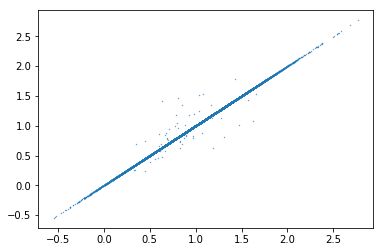

In [18]:
x = np.log10(merged_lofar_prior['f_spire_250']/1000)
y = np.log10(merged_lofar_prior['F_SPIRE_250'])
plt.scatter(x,y,s=0.1)
plt.show()

In [33]:
#merged_lofar_prior.rename_column('ra_1','ra')
#merged_lofar_prior.rename_column('dec_1','dec')
merged_lofar_prior = vstack([merged_lofar_prior,lofar[not_crossmatched]])

In [34]:
rerun_col = Column(data=merged_lofar_prior['f_spire_250'].mask,name='xid+_rerun',dtype=bool)
merged_lofar_prior.add_column(rerun_col)

In [61]:
lofar_coords = SkyCoord(merged_lofar_prior['ra'],merged_lofar_prior['dec'],unit='deg')
prior_coords = SkyCoord(prior_cat['ra'],prior_cat['dec'],unit='deg')
radius = 2
idx_prior, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    prior_coords, radius*u.arcsec)

In [36]:
uniq_ids_prior,counts_prior = np.unique(idx_lofar,return_counts=True)
source_type = np.zeros(len(merged_lofar_prior))
source_type[uniq_ids_prior] = counts_prior

In [74]:
np.min(d2d[idx_lofar==3]).value
d2d[idx_lofar==3]
np.max(d2d.value*3600)

1.9734551950306278

In [37]:
#there may be a problem here NEEDS TO BE DOUBLE CHECKED
min_d2d_prior_val = [np.min(d2d[idx_lofar==i].value) for i in uniq_ids_prior]
min_d2d_prior = np.ones(len(merged_lofar_prior))
min_d2d_prior[uniq_ids_prior] = min_d2d_prior_val

In [40]:
lofar_coords = SkyCoord(merged_lofar_prior['ra'],merged_lofar_prior['dec'],unit='deg')
help_coords = SkyCoord(help_masterlist['ra'],help_masterlist['dec'],unit='deg')
radius = 2
idx_help, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    help_coords, radius*u.arcsec)

In [41]:
uniq_ids_help,counts_help = np.unique(idx_lofar,return_counts=True)
source_type_help = np.zeros(len(merged_lofar_prior))
source_type_help[uniq_ids_help] = counts_help

In [42]:
min_d2d_help_val = [np.min(d2d[idx_lofar==i].value) for i in uniq_ids_help]
min_d2d_help = np.ones(len(merged_lofar_prior))
min_d2d_help[uniq_ids_help] = min_d2d_help_val

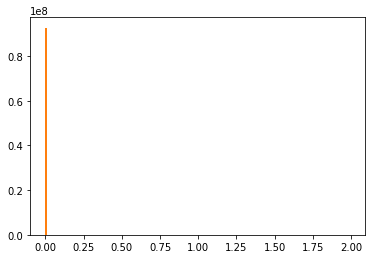

In [59]:
bins = np.arange(0,2,0.01)
plt.hist(min_d2d_help_val*3600,bins=bins)
plt.hist(min_d2d_prior_val*3600,bins=bins)
plt.show()

In [58]:
min_d2d_help_val

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [258]:
source_class = np.where((min_d2d_help<min_d2d_prior),'nearer_non_prior','nearest_prior')
source_class = np.where((min_d2d_help==min_d2d_prior),'no nearby sources',source_class)
#source_class = np.array(['nearest_prior' for i in range(len(merged_lofar_prior))])
source_class = np.where(source_type==0,'radio_position',source_class)
source_class = np.where(source_type>1,'multiple_prior',source_class)

source_class = source_class.astype('U42')

mask = (source_type>0) & (min_d2d_help>min_d2d_prior)
for i,source in enumerate(source_class):
    if mask[i]==True:

        source_class[i] = source_class[i] + '_with_nearer_non_prior'


In [262]:
class_col = Column(data=source_class,name='prior_type')
merged_lofar_prior.add_column(class_col)

In [267]:
colnames_keep = ['Source_id',
 'Isl_id',
 'RA',
 'E_RA',
 'DEC',
 'E_DEC',
 'Total_flux',
 'E_Total_flux',
 'Peak_flux',
 'E_Peak_flux',
 'RA_max',
 'E_RA_max',
 'DEC_max',
 'E_DEC_max',
 'Maj',
 'E_Maj',
 'Min',
 'E_Min',
 'PA',
 'E_PA',
 'Maj_img_plane',
 'E_Maj_img_plane',
 'Min_img_plane',
 'E_Min_img_plane',
 'PA_img_plane',
 'E_PA_img_plane',
 'DC_Maj',
 'E_DC_Maj',
 'DC_Min',
 'E_DC_Min',
 'DC_PA',
 'E_DC_PA',
 'DC_Maj_img_plane',
 'E_DC_Maj_img_plane',
 'DC_Min_img_plane',
 'E_DC_Min_img_plane',
 'DC_PA_img_plane',
 'E_DC_PA_img_plane',
 'Isl_Total_flux',
 'E_Isl_Total_flux',
 'Isl_rms',
 'Isl_mean',
 'Resid_Isl_rms',
 'Resid_Isl_mean',
 'S_Code',
 'FLAG_OVERLAP_1',
 'flag_clean_1',
 'Source_Name',
 'lr_fin',
 'lr_dist_fin',
 'lr_index_fin',
 'ra',
 'dec',
 'ra_2',
 'dec_2',
 'help_id',
 'f_spire_250',
 'ferr_spire_250',
 'flag_spire_250',
 'f_spire_350',
 'ferr_spire_350',
 'flag_spire_350',
 'f_spire_500',
 'ferr_spire_500',
 'flag_spire_500',
 'flag_optnir_det',
 'f_mips_24',
 'bayes.dust.luminosity',
 'bayes.dust.luminosity_err',
 'best.universe.redshift',
 'xid+_rerun',
 'prior_type']

In [268]:
merged_lofar_prior = merged_lofar_prior[colnames_keep]

In [269]:
Table.write(merged_lofar_prior,'data/xid+_prepared_cat.fits')

In [ ]:
test = Table.read()